# ASTR302 Lab 6: Instrumental Stellar Photometry

In this Lab you will calculate instrumental stellar magnitudes.

## Finding and centering on stars

Counting the number of photons in the image of a star should be straightforward. However, there are two factors that complicate this calculation. First, the star, which is effectively a point source (i.e. unresolved at any likely diffraction limit with the possible exception of some nearby red giants and optical interferometry - which we are not dealing with here), are smeared out by the atmosphere. Second, the background light, which may be non-uniform and contaminated by other resolved objects, pollutes our star of interest. We will deal with both of those factors here.


Before we start, lets import the packages you will be needing for this Lab and take a look at the image just to make sure. We will be using photutils from astropy. For more on this see https://photutils.readthedocs.io/en/stable/

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import astropy as astro
#from scipy import stats
#from scipy.optimize import curve_fit

from astropy.io import fits
from astropy.wcs import WCS

!pip install --upgrade pip
!pip install photutils

from photutils.detection import DAOStarFinder
from astropy.stats import mad_std

from astropy.stats import sigma_clipped_stats
from astropy.stats import SigmaClip

from astropy import units as u
from photutils.background import Background2D, MedianBackground
from photutils.aperture import aperture_photometry, CircularAnnulus, CircularAperture

import csv


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


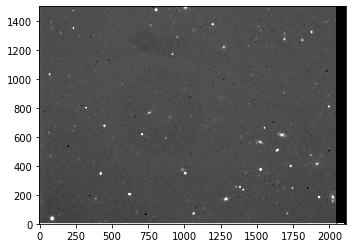

In [18]:
# define the image, open, and read the header information - use your reduced image from the previous workbook

filename = 'imacs_image.fits'
hdu = fits.open(filename)[0]
image = hdu.data
hdr = hdu.header

plt.imshow(image, origin='lower', cmap='Greys_r',vmin=1100,vmax=1480)

Lets start by subtracting out the smooth background in the image. We could simply assume a constant value (e.g., the mean or mode of the image), but usually the background has astronomical sources in it, so we'll try something a bit more sophisticated.

In [19]:
# caculate statistics of image clipping 3sigma outliers
mean, median, std = sigma_clipped_stats(image, sigma=3.0)
print((mean, median, std))  

(1190.236571798087, 1190.0, 27.400498767987617)


However, the background also generally has large scale structure across the image, so we should try fitting (and subtracting) a 2-D model of the background (it doesn't make much difference in this example, but it can in other data).

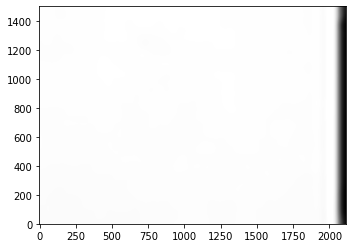

In [20]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()

bkg = Background2D(image, (50, 50), filter_size=(3,3),sigma_clip=sigma_clip,bkg_estimator=bkg_estimator)

plt.imshow(bkg.background, origin='lower', cmap='Greys_r',interpolation='nearest')

image = image - bkg.background

<div class="alert alert-info"> What is that band on the right? Did we forget to do something to this image?</div>

Answer: 

<div class="alert alert-info"> Go ahead and correct the image (skip the flat fielding) and then redo the 2-D background fit.</div>

Write your code here:

Now we will go ahead and use a routing from DAOPhot to find the stars. In this case we are setting the FWHM of the stars to 4 pixels and only selecting sources that are greater than 5sigma detections above the background noise. This gives us the coordinates of the sources, and other ancillary information. For example the sharpness is a measure of how extended/compact the source is. The mag is an estimate of the instrumental magnitude. But we want to do a better job on determining the instrumental magnitude.

In [81]:
bkg_sigma = mad_std(image)  

daofind = DAOStarFinder(fwhm=4.0, threshold=10.0 * bkg_sigma)  

sources = daofind(image)  

for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output

print(sources)  

 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag     
--- --------- --------- ---------- ... --- --------- --------- ------------
  1 89.962385 36.466997 0.40846817 ...   0 27581.065 60.239498   -4.4497034
  2 1063.1108 71.740175  0.4476804 ...   0  1159.256 1.9870015  -0.74549549
  3 1285.9933 170.77779 0.46150766 ...   0 1102.1204 1.2792068  -0.26735192
  4 1926.7635 184.53355 0.41135488 ...   0 2647.6532 5.5262095   -1.8560684
  5 2021.0633 184.67008 0.42941417 ...   0 992.65548 1.5840659  -0.49943313
  6 626.20266  203.6393 0.46212811 ...   0   2215.72 4.6300195   -1.6639571
  7 617.55393 204.91302 0.29982794 ...   0  782.9558 1.7464421  -0.60538546
  8 1404.2344 235.46515 0.46661733 ...   0 959.82664 2.0439829  -0.77619314
  9 1382.5725 254.21849 0.37103926 ...   0 1013.7959 2.3950279  -0.94827643
 10 424.01006 346.64451 0.43837121 ...   0 3421.1598 7.4862932   -2.1856671
...       ...       ...        ... ... ...       ...       ...          ...
 24 1994.715

A difficulty in assessing the total instrumental magnitude of a star (or any object) is that some of the flux from that objects gets scattered to large radii. However, if we set the aperture to be very large then we end up including flux from other nearby sources. The compromise is to use a small aperture for every object and use (isolated) stars to determine the fraction of the light that gets scattered outside of this small aperture. In this first cell we measure aperture magnitudes for a set of apertures randing from 3 to 40 pixels.

In [82]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  

radii = [3.0, 4.0, 5.0,7.0,10.0,15.0,25.0,40.0]

apertures = [CircularAperture(positions, r=r) for r in radii]

phot_table = aperture_photometry(image, apertures)

header = []
for col in phot_table.colnames:

    phot_table[col].info.format = '%.8g'  # for consistent table output
    header = np.append(header,col)

# save the output for next notebook
f = open('photometry.csv', 'w')

writer = csv.writer(f)
writer.writerow(header)

for i in range(0,len(phot_table)):
    writer.writerow(phot_table[i])

f.close()

In this next cell we show where the apertures are. You will have to adjust the plt.imshow limits to get a good view of the image.

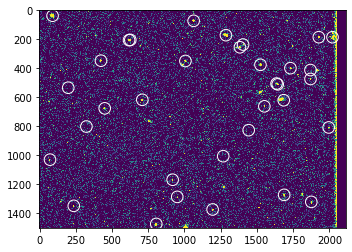

In [83]:
plt.imshow(image,interpolation='nearest',vmin=10, vmax=100)
aperture = CircularAperture(positions, r=40)
ann_patches = aperture.plot(color='white',lw=1)

Text(0, 0.5, 'Flux Fraction')

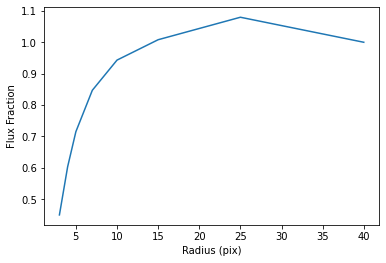

In [84]:
# curve of growth

import pandas as pd
last = len(phot_table.columns)

column = []

for j in range(0,len(phot_table)):
    column.append([])
    for i in range(3,last):
        column[-1].append(phot_table[j][i]/phot_table[j][last-1])

df = pd.DataFrame(column)        
df = df[(df[0]>0.3) & (df[0]<1) & (df[1]>0.3) & (df[1] < 1)]

ap_frac = []
for i in range(3,last):
    ap_frac = np.append(ap_frac,df[i-3].mean())

plt.plot(radii,ap_frac)  
plt.xlabel('Radius (pix)')
plt.ylabel('Flux Fraction')

<div class="alert alert-info"> Is there anything "troubling" about the results? If so, describe, investigate and apply a solution. If not, choose an aperture and aperture correction. Describe your reasoning.</div>

Answer and/or code in here:

## Conclusion: 

 <div class="alert alert-info">Save your notebook.  Append your LastNameFirstInitial to the filename and submit via D2L. </div>